# tobac example: 
## Tracking deep convection based on VIS from geostationary satellite retrievals

This example notebook demonstrates the use of tobac to track isolated deep convective clouds based on radiances within the VIS using channel 2 (red light - 600 nm) of the GOES-16 imaging instrument in 5-min resolution. The study area is loacted within the CONUS extent of the GOES-E for investigating the formation of deep convection over the Carribean, following the [EUREC4A](eurec4a.eu) initiaive. 

The data used in this example is saved on the cloud of the Amazon Web Services, providing an efficient way of processing satellite data without facing the need of downloading the data. 

In this example, the [Cloud and Moisture Imagery data](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C01502) (ABI-L2-CMIPC) data set is used for the cloud tracking. The product contains one or more Earth-view images with pixel values identifying brightness values that are scaled to support visual analysis. Also, the data includes quality information. 

Further information on the AWS and provided data sets can be found [here](https://registry.opendata.aws/noaa-goes/).

**Configurations needed for conducting the example:**

In [17]:
# Import libraries
import requests
import netCDF4
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from pyproj import Proj, transform, Transformer
from pyproj import transformer

import xarray
import numpy as np
from numpy import ma
import pandas as pd
import os
from six.moves import urllib
from glob import glob
from scipy import interpolate
import cv2 as cv

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import tobac itself:
import tobac

In [3]:
# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

**Build access to Amazon Web Server where GOES-16 data are stored:**

In [4]:
# For acessing data from AWS bucket define bucket specifics:
bucket_name = 'noaa-goes16'
product_name = 'ABI-L2-CMIPC'
year = 2020
day_of_year = 45
hour = 18
band = 2

In [5]:
# Initialize an s3 client:
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

In [6]:
# Define function for generating file name keys for the S3 bucket:
def get_s3_keys(bucket, s3_client, prefix = ''):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    """
    
    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    while True:
        resp = s3_client.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            key = obj['Key']
            if key.startswith(prefix):
                yield key

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

In [7]:
# Retrieve the keys for file names:
keys = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M6C{band:02.0f}'
                  )


keys = [key for key in keys][0:12]

In [8]:
# Print the file names of the GOES CMIPC ABI-L2 data for the selected time period
print(keys)

['ABI-L2-CMIPC/2020/045/18/OR_ABI-L2-CMIPC-M6C02_G16_s20200451800585_e20200451803358_c20200451803496.nc', 'ABI-L2-CMIPC/2020/045/18/OR_ABI-L2-CMIPC-M6C02_G16_s20200451805585_e20200451808358_c20200451808493.nc', 'ABI-L2-CMIPC/2020/045/18/OR_ABI-L2-CMIPC-M6C02_G16_s20200451810585_e20200451813358_c20200451813484.nc', 'ABI-L2-CMIPC/2020/045/18/OR_ABI-L2-CMIPC-M6C02_G16_s20200451815585_e20200451818358_c20200451818500.nc', 'ABI-L2-CMIPC/2020/045/18/OR_ABI-L2-CMIPC-M6C02_G16_s20200451820585_e20200451823358_c20200451823498.nc', 'ABI-L2-CMIPC/2020/045/18/OR_ABI-L2-CMIPC-M6C02_G16_s20200451825585_e20200451828358_c20200451828489.nc', 'ABI-L2-CMIPC/2020/045/18/OR_ABI-L2-CMIPC-M6C02_G16_s20200451830585_e20200451833358_c20200451833494.nc', 'ABI-L2-CMIPC/2020/045/18/OR_ABI-L2-CMIPC-M6C02_G16_s20200451835585_e20200451838358_c20200451838489.nc', 'ABI-L2-CMIPC/2020/045/18/OR_ABI-L2-CMIPC-M6C02_G16_s20200451840585_e20200451843358_c20200451843482.nc', 'ABI-L2-CMIPC/2020/045/18/OR_ABI-L2-CMIPC-M6C02_G16_s2

**Request data from AWS S3 server using the keys we defined and store all files to one data set:**

In [9]:
for k in range(len(keys)):
    resp = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{keys[k]}')
    file_name = keys[k].split('/')[-1].split('.')[0]
    nc4_ds = netCDF4.Dataset(file_name, memory = resp.content)
    store = xarray.backends.NetCDF4DataStore(nc4_ds)
    if k == 0:
        DS = xarray.open_dataset(store)    
    else:
        DS2 = xarray.open_dataset(store)
        DS = xarray.combine_nested([DS, DS2], concat_dim=["t"], combine_attrs = "override")

In [10]:
# Inspect the obtained data set which includes 3 dimensions (time, y = lat, x = lon) as well as metadata:
DS

<xarray.Dataset>
Dimensions:                                           (band: 1, number_of_image_bounds: 2, number_of_time_bounds: 2, t: 12, x: 10000, y: 6000)
Coordinates:
  * t                                                 (t) datetime64[ns] 2020...
  * y                                                 (y) float32 0.1282 ... ...
  * x                                                 (x) float32 -0.1014 ......
    y_image                                           float32 0.08624
    x_image                                           float32 -0.03136
    band_id                                           (band) int8 2
    band_wavelength                                   (band) float32 0.64
Dimensions without coordinates: band, number_of_image_bounds, number_of_time_bounds
Data variables:
    CMI                                               (t, y, x) float32 nan ....
    DQF                                               (t, y, x) float32 nan ....
    time_bounds                                       (t, number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            (t) int32 -2147483647 ....
    y_image_bounds                                    (t, number_of_image_bounds) float32 ...
    x_image_bounds                                    (t, number_of_image_bounds) float32 ...
    nominal_satellite_subpoint_lat                    (t) float64 0.0 ... 0.0
    nominal_satellite_subpoint_lon                    (t) float64 -75.2 ... -...
    nominal_satellite_height                          (t) float64 3.579e+04 ....
    geospatial_lat_lon_extent                         (t) float32 9.969e+36 ....
    valid_pixel_count                                 (t) float64 5.924e+07 ....
    outlier_pixel_count                               (t) float64 0.0 ... 0.0
    total_number_of_points                            (t) float64 5.925e+07 ....
    min_reflectance_factor                            (t) float64 0.0006142 ....
    max_reflectance_factor                            (t) float64 0.9765 ... ...
    mean_reflectance_factor                           (t) float64 0.1838 ... ...
    std_dev_reflectance_factor                        (t) float64 0.1633 ... ...
    algorithm_dynamic_input_data_container            (t) int32 -2147483647 ....
    percent_uncorrectable_GRB_errors                  (t) float64 0.0 ... 0.0
    percent_uncorrectable_L0_errors                   (t) float64 0.0 ... 0.0
    earth_sun_distance_anomaly_in_AU                  (t) float64 0.9875 ... ...
    processing_parm_version_container                 (t) int32 -2147483647 ....
    algorithm_product_version_container               (t) int32 -2147483647 ....
    esun                                              (t) float64 1.631e+03 ....
    kappa0                                            (t) float64 0.001878 .....
    planck_fk1                                        (t) float64 nan ... nan
    planck_fk2                                        (t) float64 nan ... nan
    planck_bc1                                        (t) float64 nan ... nan
    planck_bc2                                        (t) float64 nan ... nan
    focal_plane_temperature_threshold_exceeded_count  (t) float64 nan ... nan
    maximum_focal_plane_temperature                   (t) float64 nan ... nan
    focal_plane_temperature_threshold_increasing      (t) float64 nan ... nan
    focal_plane_temperature_threshold_decreasing      (t) float64 nan ... nan
Attributes:
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           NSOF
    production_environment:    OE
    spatial_resolution:        0.5km at nadir
    orbital_slot:              GOES-East
    platform

**Crop the CONUS extent to the AOI of the Carribean without resampling the data:**

Functions applied here are provided by Will Jones, check [Example Notebooks](https://github.com/w-k-jones/example_notebooks) for further information.

In [11]:
# Selecting a Bounding Box based on Lat- and Lon-Coordinates:
ll_bbox=(-70,10,-55,20) #xmin,ymin,xmax,ymax

In [12]:
# Functions for getting GOES Projection Properties and respective Lon-/Lat-Values 
def get_abi_proj(dataset):
    return Proj(proj='geos', h=dataset.goes_imager_projection.perspective_point_height,
                lon_0=dataset.goes_imager_projection.longitude_of_projection_origin,
                lat_0=dataset.goes_imager_projection.latitude_of_projection_origin,
                sweep=dataset.goes_imager_projection.sweep_angle_axis)

def get_abi_lat_lon(dataset, dtype=float):
    p = get_abi_proj(dataset)
    xx, yy = np.meshgrid((dataset.x.data*dataset.goes_imager_projection.perspective_point_height).astype(dtype),
                         (dataset.y.data*dataset.goes_imager_projection.perspective_point_height).astype(dtype))
    lons, lats = p(xx, yy, inverse=True)
    lons[lons>=1E30] = np.nan
    lats[lats>=1E30] = np.nan
    return lats, lons

In [13]:
# Function for cropping based on the Bounding Box by transforming the coordinates within the AOI 
# to GOES native coordinates: 
def ll_bound(abi_ds, ll_bbox):
    geo_p = get_abi_proj(abi_ds)
    x, y = geo_p([ll_bbox[0], ll_bbox[0], ll_bbox[2], ll_bbox[2]], 
                 [ll_bbox[1], ll_bbox[3], ll_bbox[1], ll_bbox[3]])
    
    x = [xi if np.isfinite(xi) else np.nan for xi in x]
    y = [yi if np.isfinite(yi) else np.nan for yi in y]
    
    xy_bbox = (np.nanmin(x)/abi_ds.goes_imager_projection.perspective_point_height, 
               np.nanmin(y)/abi_ds.goes_imager_projection.perspective_point_height, 
               np.nanmax(x)/abi_ds.goes_imager_projection.perspective_point_height, 
               np.nanmax(y)/abi_ds.goes_imager_projection.perspective_point_height)
    
    return abi_ds.isel({'x':np.logical_and(abi_ds.x>xy_bbox[0], abi_ds.x<xy_bbox[2]),
                        'y':np.logical_and(abi_ds.y>xy_bbox[1], abi_ds.y<xy_bbox[3])})

In [14]:
# Apply cropping function to data set:
DS_BB = ll_bound(DS, ll_bbox)

#inProj = Proj(proj='geos', h=DS.goes_imager_projection.perspective_point_height,
#                lon_0=DS.goes_imager_projection.longitude_of_projection_origin,
#                lat_0=DS.goes_imager_projection.latitude_of_projection_origin,
#                sweep=DS.goes_imager_projection.sweep_angle_axis)
#transformer = Transformer.from_crs(str(inProj),
#                                  'epsg:4326')
#xx, yy = np.meshgrid(DS_BB.x,DS_BB.y)
#xx,yy = transformer.transform(xx,yy)

In [15]:
from mpl_toolkits.basemap import Basemap 

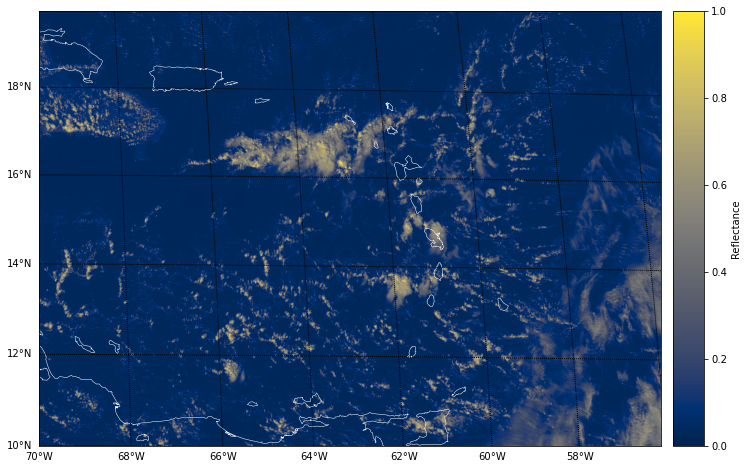

In [18]:
# Plot AOI extent with GOES projection:
plt.figure(figsize=(16,8))
bmap = Basemap(llcrnrlon=-70,llcrnrlat=10,urcrnrlon=-55,urcrnrlat=20,
             resolution='i', projection='geos', lat_0 = 0, lon_0 = -75.0, ellps='GRS80')

bmap.imshow(DS_BB["CMI"][6], origin='upper', vmin=0, vmax=1, cmap='cividis')
bmap.drawcoastlines(linewidth=0.5, linestyle='solid', color='white')
bmap.drawcountries(linewidth=0.5, linestyle='solid', color='white')
bmap.drawparallels(np.arange(8,22,2),labels=[1,0,0,0])
bmap.drawmeridians(np.arange(-70,-50,2),labels=[0,0,0,1])
bmap.colorbar(location='right', label='Reflectance')

**Data manipulation:**
Set up directories and convert coordinates to more a convenient lat-/lon-format.

In [19]:
# Set up directory to save output and plots:
savedir='Save'
if not os.path.exists(savedir):
    os.makedirs(savedir)
plot_dir="Plot"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [21]:
# Convert coordinate values to lat-/lon-format for detection:
lon_origin = DS_BB.goes_imager_projection.longitude_of_projection_origin
H = DS_BB.goes_imager_projection.perspective_point_height+DS_BB.goes_imager_projection.semi_major_axis
r_eq = DS_BB.goes_imager_projection.semi_major_axis
r_pol = DS_BB.goes_imager_projection.semi_minor_axis

# grid info
lat_rad_1d = DS_BB.variables['x'][:]
lon_rad_1d = DS_BB.variables['y'][:]

# create meshgrid filled with radian angles
lat_rad,lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)

# lat/lon calc routine from satellite radian angle vectors
lambda_0 = (lon_origin*np.pi)/180.0

a_var = np.power(np.sin(lat_rad),2.0) + (np.power(np.cos(lat_rad),2.0)*(np.power(np.cos(lon_rad),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(lon_rad),2.0))))
b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
c_var = (H**2.0)-(r_eq**2.0)

r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)

s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
s_y = - r_s*np.sin(lat_rad)
s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)

# latitude and longitude projection for plotting data on traditional lat/lon maps
lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)

print(lon)
print(lat)

[[-69.99993  -69.99504  -69.990166 ... -61.430256 -61.42521  -61.42012 ]
 [-70.0001   -69.99521  -69.990326 ... -61.43072  -61.425682 -61.420578]
 [-70.00029  -69.99539  -69.99052  ... -61.431274 -61.426243 -61.421112]
 ...
 [-70.1724   -70.16769  -70.16298  ... -61.911957 -61.907135 -61.902184]
 [-70.17255  -70.16783  -70.163124 ... -61.91227  -61.907448 -61.902496]
 [-70.17267  -70.167946 -70.16324  ... -61.912613 -61.907784 -61.902866]]
[[19.996578 19.99667  19.996693 ... 20.081724 20.081758 20.08185 ]
 [19.991674 19.991766 19.991774 ... 20.076778 20.076813 20.076916]
 [19.986685 19.986778 19.986786 ... 20.071726 20.071743 20.07189 ]
 ...
 [14.582905 14.582935 14.582944 ... 14.640847 14.640834 14.640955]
 [14.578084 14.578115 14.578125 ... 14.636091 14.636078 14.636199]
 [14.573305 14.573368 14.573377 ... 14.631306 14.631304 14.631382]]


In [25]:
DS_BB["x"] = lon[0,:]
DS_BB["y"] = lat[:,0]

In [26]:
# Rename Attributes (standard_name is a given argument for iris_cube function):
DS_BB.CMI.attrs["standard_name"] = "toa_bidirectional_reflectance"
print(DS_BB.CMI.attrs)

{'long_name': 'ABI L2+ Cloud and Moisture Imagery reflectance factor', 'standard_name': 'toa_bidirectional_reflectance', 'sensor_band_bit_depth': 12, 'valid_range': array([   0, 4095], dtype=int16), 'units': '1', 'resolution': 'y: 0.000014 rad x: 0.000014 rad', 'grid_mapping': 'goes_imager_projection', 'cell_methods': 't: point area: point', 'ancillary_variables': 'DQF'}


In [29]:
# Assign former coordinates as variables to avoid dupplicate naming:
new_data = DS_BB.reset_coords(names = ["y_image", "x_image", "band_id", "band_wavelength"])

**Feature identification:**
Identify features based on OLR field and a set of threshold values.

In [30]:
# Determine temporal and spatial sampling of the input data:
dxy,dt=tobac.utils.get_spacings(new_data.CMI,grid_spacing=500)

In [31]:
# Keyword arguments for the feature detection step
parameters_features={}
parameters_features['position_threshold']='center'
parameters_features['sigma_threshold']=0.5
parameters_features['min_num']=4
parameters_features['target']='maximum'
parameters_features['threshold']=0.6

In [32]:
# Feature detection and save results to file:
print('starting feature detection')
Features=tobac.themes.tobac_v1.feature_detection_multithreshold(new_data.CMI,dxy,**parameters_features)
#Features.to_netcdf(os.path.join(savedir,'Features.nc'))
print('feature detection performed and saved')

starting feature detection
       frame  idx       hdim_1       hdim_2  num  threshold_value  feature  \
0          0    1     9.000000  1404.000000    1              0.6        1   
1          0    2    19.500000  1392.000000    2              0.6        2   
2          0    3    20.000000  1434.000000    1              0.6        3   
3          0    4    34.000000  1383.000000    1              0.6        4   
4          0    5    36.000000  1396.000000    1              0.6        5   
...      ...  ...          ...          ...  ...              ...      ...   
13590     11  926  1107.478261   297.217391   23              0.6    13591   
13591     11  927  1107.500000  1647.500000    2              0.6    13592   
13592     11  928  1108.000000   829.000000    1              0.6    13593   
13593     11  929  1109.333333   279.333333    3              0.6    13594   
13594     11  930  1110.750000   764.250000    8              0.6    13595   

                      time          

**Segmentation:**  
Segmentation is performed based on the OLR field and a threshold value to determine the cloud areas.

In [33]:
# Keyword arguments for the segmentation step:
parameters_segmentation={}
parameters_segmentation['target']='maximum'
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=0.6

In [34]:
# Perform segmentation and save results to files:
Mask_VIS,Features_VIS=tobac.themes.tobac_v1.segmentation(Features,new_data.CMI,dxy,**parameters_segmentation)
print('segmentation VIS performed, start saving results to files')
#Mask_VIS.to_netcdf(os.path.join(savedir,'Mask_Segmentation_VIS.nc'))              
#Features_VIS.to_netcdf(os.path.join(savedir,'Features_VIS.nc'))
print('segmentation VIS performed and saved')

<xarray.DataArray 'CMI' (t: 12, y: 1113, x: 1731)>
array([[[0.0428571 , 0.03396822, 0.03269838, ..., 0.03460314,
         0.03587298, 0.03999996],
        [0.0460317 , 0.08031739, 0.04317456, ..., 0.03714282,
         0.04031742, 0.09111103],
        [0.0301587 , 0.03460314, 0.02825394, ..., 0.03873012,
         0.04031742, 0.05365074],
        ...,
        [0.05111106, 0.0333333 , 0.03746028, ..., 0.35777745,
         0.34634888, 0.33714253],
        [0.03746028, 0.03523806, 0.0365079 , ..., 0.35523775,
         0.34444413, 0.33650762],
        [0.03587298, 0.03587298, 0.03460314, ..., 0.36507902,
         0.33936477, 0.32126954]],

       [[0.02952378, 0.0285714 , 0.02920632, ..., 0.03523806,
         0.06317455, 0.05365074],
        [0.02793648, 0.02888886, 0.02984124, ..., 0.03206346,
         0.0412698 , 0.04222218],
        [0.02920632, 0.02825394, 0.0301587 , ..., 0.03873012,
         0.03873012, 0.04952376],
...
        [0.06126978, 0.0714285 , 0.06984121, ..., 0.2565077 ,
    

**Trajectory linking:**
The detected features are linked into cloud trajectories using the trackpy library (http://soft-matter.github.io/trackpy). This takes the feature positions determined in the feature detection step into account but does not include information on the shape of the identified objects.

In [35]:
# keyword arguments for linking step
parameters_linking={}
parameters_linking['v_max']=50
parameters_linking['stubs']=3
parameters_linking['order']=1
parameters_linking['extrapolate']=1
parameters_linking['memory']=0
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['subnetwork_size']=100
parameters_linking['method_linking']= 'predict'

In [36]:
# Perform linking and save results to file:
Track=tobac.themes.tobac_v1.linking_trackpy(Features,new_data.CMI,dt=dt,dxy=dxy,**parameters_linking)
#Track.to_netcdf(os.path.join(savedir,'Track.nc'))

Frame 11: 930 trajectories present.


In [37]:
Track

<xarray.Dataset>
Dimensions:          (index: 13595)
Coordinates:
  * index            (index) int64 0 1 2 3 4 5 ... 13590 13591 13592 13593 13594
Data variables:
    frame            (index) int64 0 0 0 0 0 0 0 0 0 ... 11 11 11 11 11 11 11 11
    idx              (index) int64 1 2 3 4 5 6 7 ... 924 925 926 927 928 929 930
    hdim_1           (index) float64 9.0 19.5 20.0 ... 1.109e+03 1.111e+03
    hdim_2           (index) float64 1.404e+03 1.392e+03 ... 279.3 764.2
    num              (index) int64 1 2 1 1 1 1 6 3 2 5 ... 4 1 3 4 1 23 2 1 3 8
    threshold_value  (index) float64 0.6 0.6 0.6 0.6 0.6 ... 0.6 0.6 0.6 0.6 0.6
    feature          (index) int64 1 2 3 4 5 6 ... 13591 13592 13593 13594 13595
    time             (index) object 2020-02-14 18:02:17 ... 2020-02-14 18:57:17
    timestr          (index) object '2020-02-14 18:02:17' ... '2020-02-14 18:...
    y                (index) float64 19.95 19.9 19.9 19.83 ... 14.59 14.59 14.58
    x                (index) float64 -63.07 -63.13 -62.92 ... -68.64 -66.25
    cell             (index) object nan 2 nan 4 nan ... 1241 nan 3239 nan 2680
    time_cell        (index) timedelta64[ns] NaT 00:00:00 NaT ... NaT 00:25:00

**Visualisation:** 

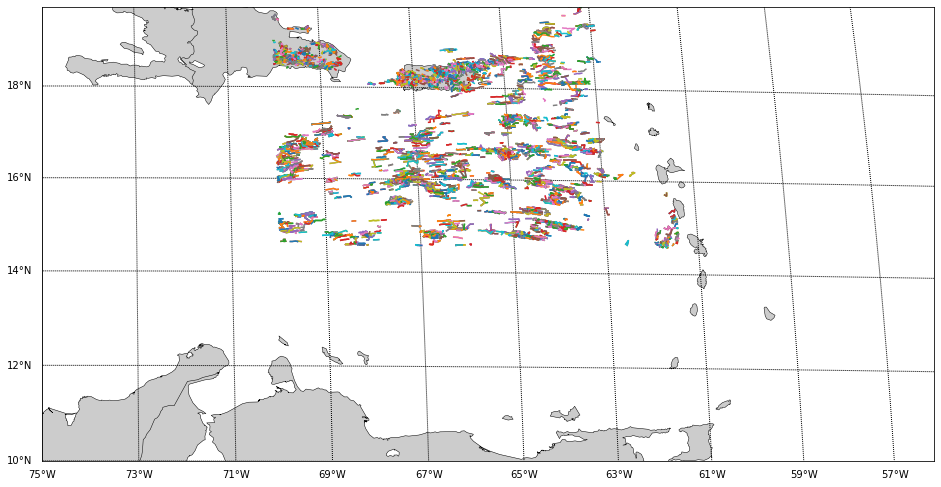

In [38]:
plt.figure(figsize=(16,12))
tmap = Basemap(
    llcrnrlon=-75,llcrnrlat=10,urcrnrlon=-55,urcrnrlat=20,
             resolution='i', projection='geos', 
    lat_0 = 0, lon_0 = -75.0, ellps='GRS80', satellite_height = 35786023.0)
tmap.fillcontinents()
tmap.drawcoastlines(linewidth=0.5, linestyle='solid', color='black')
tmap.drawcountries(linewidth=0.5, linestyle='solid', color='black')
tmap.drawparallels(np.arange(10,20,2),labels=[1,0,0,0])
tmap.drawmeridians(np.arange(-75,-55,2),labels=[0,0,0,1])

cell_id = np.unique(Track["cell"])
cell_id = cell_id.tolist()
cell_id = [x for x in cell_id if ~np.isnan(x)]
#cell_id = cell_id[0:100]

#inProj = Proj(proj='geos', h=DS.goes_imager_projection.perspective_point_height,
#                lon_0=DS.goes_imager_projection.longitude_of_projection_origin,
#                lat_0=DS.goes_imager_projection.latitude_of_projection_origin,
#                sweep=DS.goes_imager_projection.sweep_angle_axis)
#print(inProj)
#transformer = Transformer.from_crs(str(inProj),
#                                  'epsg:4326', always_xy=True)

for cell in cell_id:  
 track_i = Track.where(Track["cell"]==cell, drop=True)
 x,y = track_i['x'].values.tolist(), track_i['y'].values.tolist()
 #x,y = transformer.transform(x,y)
 #x,y = tmap(x,y)
 #if cell == 2:   
 # print(x)
 # print(y)
#x = [-75,-74.5,-74]
#y = [0,0,0]
 #x,y = tmap(x,y)
 tmap.plot(x,y,markersize=.3,latlon=True)


In [58]:
cell = 89
track_i = Track.where(Track["cell"]==cell, drop=True)
x, y = track_i['projection_x_coordinate'].values.tolist(), track_i['projection_y_coordinate'].values.tolist()
x, y = transformer.transform(x,y)
print(x)
print(y)

[5.11686908293026e-07, 5.119544927300144e-07, 5.120811012095912e-07, 5.119544927300144e-07]
[-74.99999976815973, -74.99999976827954, -74.99999976853105, -74.9999997693436]


In [39]:
# Set extent of maps created in the following cells:
axis_extent=[-70,10,-55,20]

In [44]:
import cartopy.crs as ccrs
projection=ccrs.Geostationary(central_longitude=-75, sweep_axis="x")

In [40]:
# Create animation of tracked clouds and outlines with OLR as a background field
animation_test_tobac=tobac.plot.animation_mask_field(Track,Features,new_data.CMI,Mask_VIS,
                                          axis_extent=axis_extent,#figsize=figsize,orientation_colorbar='horizontal',pad_colorbar=0.2,
                                          vmin=0,vmax=1,cmap='Blues_r',
                                          plot_outline=True,plot_marker=True,marker_track='x',plot_number=True,plot_features=True)

In [41]:
# Display animation:
from IPython.display import HTML, Image, display
HTML(animation_test_tobac.to_html5_video())

CoordinateNotFoundError: 'Expected to find exactly 1 longitude coordinate, but found none.'

Text(0, 0.5, 'counts')

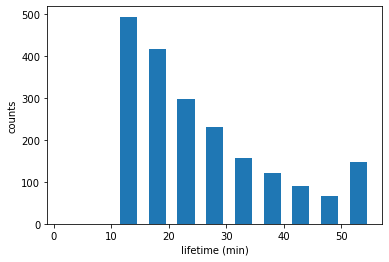

In [42]:
# Lifetimes of tracked clouds:
fig_lifetime,ax_lifetime=plt.subplots()
tobac.plot.plot_lifetime_histogram_bar(Track,axes=ax_lifetime,bin_edges=np.arange(0,60,5),density=False,width_bar=3)
ax_lifetime.set_xlabel('lifetime (min)')
ax_lifetime.set_ylabel('counts')